# DDW TASK 2

## Contribution
- Jia Hui - Brainstormed on features, researching, model experimenting
- Pei Xuan - Brainstormed on features, researching, data cleaning
- Min Khant - Brainstormed on features, researching

## Problem Statement

We aim to predict the number of ICU admissions using:

1. Number of days from the introduction of Delta variant
2. Measurement of visitors to transit areas

## Link to Data Sources
### 
*Number of ICU Admissions in United Kingdom*
- [ICU Admissions](https://coronavirus.data.gov.uk/details/healthcare)

*Change in Visitors to Transit Areas*
- [Measurement of visitors](https://ourworldindata.org/grapher/changes-visitors-covid?country=~GBR)

## Cleaning of Data
*Took data from 1/6/2021 to 8/11/2021*

## All possible models
1. **[Linear Regression](#linear)**
2. **[Polynomial Regression](#poly)**
1. **[Mutiple Regression](#multi)**

## Required Imports

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Functions

In [288]:
def normalize_z(df):
    # mean with axis 0 is summing the rows
    return (df - df.mean(axis=0)) / df.std(axis=0) 

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns) 
    feature = df_feature.to_numpy()
    number_of_samples = feature.shape[0]
    return np.concatenate((np.ones((number_of_samples,1)), feature), axis=1)

def prepare_target(df_target):
    # to_numpy() removes the first column (header column)
    return df_target.to_numpy()

def predict(df_feature, beta):
    X = prepare_feature(normalize_z(df_feature))
    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    # get the indexes of the feature 
    indexes = df_feature.index
    # seed the random value 
    if random_state != None:
        np.random.seed(random_state)
    # get the number of test samples to extract 
    k = int(test_size * len(indexes))
    # get the indexes from the features and target to select as test set 
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
  
def r2_score(y, ypred):
    sum_res = np.sum((y - ypred)**2)
    error_tot = y - np.mean(y)
    sum_tot = np.sum(error_tot**2)
    return 1-(sum_res/sum_tot)

def adjusted_r2_score(y, ypred, p):
    r2 = r2_score(y, ypred)
    N = y.shape[0]
    return 1-((1-r2)*(N-1)/(N-p-1))

def mean_squared_error(target, pred):
    n = target.shape[0]
    return 1/n * np.sum((target-pred)**2)

def compute_cost(X, y, beta):
    J = 0
    no_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error) # .T is transpose
    J = 1/(2*no_of_samples) * error_sq
    return J[0][0]

def gradient_descent(X, y, beta, alpha, num_iters):
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        # STEP 2: compute the derivate with current parameters
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # STEP 3: update the parameters
        beta = beta - alpha *  derivative_error
        # compute cost at every iteration of beta
        J_storage.append(compute_cost(X, y, beta))
    return beta, J_storage

def transform_features_power(df_feature, colname, colname_transformed, value):
    copy = df_feature.copy()
    copy.loc[:, colname_transformed] = df_feature.loc[:,colname] ** value 
    return copy

def add_feature(df_feature, colname_transformed, value):
    df_feature[colname_transformed] = value
    return df_feature

## Reading data from CSV

Text(0.5, 0, 'Delta')

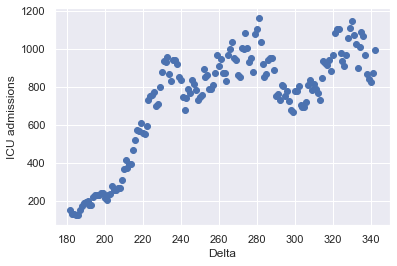

In [289]:
import matplotlib.dates as mdates
df = pd.read_csv("DDW_dataset1.csv")

df_feature_delta, df_target = get_features_targets(df,["Delta"],["ICU admissions"])
plt.scatter(df_feature_delta, df_target)
plt.ylabel("ICU admissions")
plt.xlabel("Delta")

Text(0.5, 0, 'Transit')

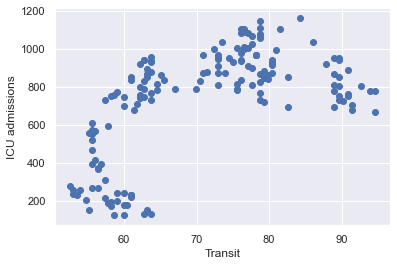

In [290]:
df_feature_transit, df_target = get_features_targets(df,["Transit"],["ICU admissions"])
plt.scatter(df_feature_transit, df_target)
plt.ylabel("ICU admissions")
plt.xlabel("Transit")

## **Linear Regression**
<a id="linear"></a>

### **Delta**

[[736.00864078]
 [218.43540353]]


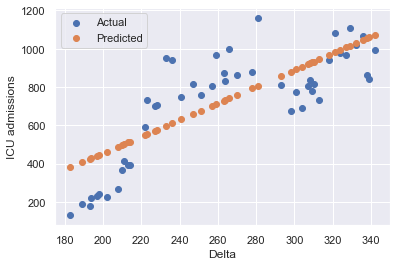

In [291]:
# Delta
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_delta, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

print(beta)
pred = predict(df_features_test, beta)

sns.set()
plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Delta")
plt.legend()

In [292]:
# TESTS
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 2)
print(a_r2, "Adjusted")


0.6145767950420407 Adjusted


### **Transit**

[[736.00864078]
 [167.81434843]]


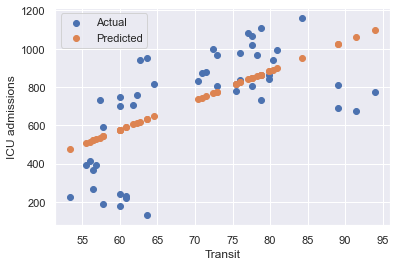

In [293]:
# Transit
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_transit, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

print(beta)
pred = predict(df_features_test, beta)

sns.set()
plt.scatter(df_features_test["Transit"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Transit")
plt.legend()

In [294]:
# TESTS
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 2)
print(a_r2, "Adjusted")


0.38186753617334324 Adjusted


## **Polynomial Linear Regression**
<a id="poly"></a>

### **Delta**

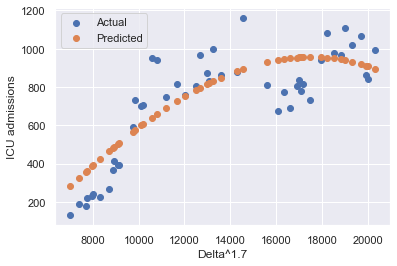

In [295]:
df_features_second = transform_features_power(df_feature_delta, 'Delta', 'Delta^1.7', 1.7)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^5', 5.5)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^6', 6)


# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((5,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# print(beta)
pred = predict(df_features_test, beta)

sns.set()

plt.scatter(df_features_test["Delta^1.7"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^1.7"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Delta^1.7")
plt.legend()


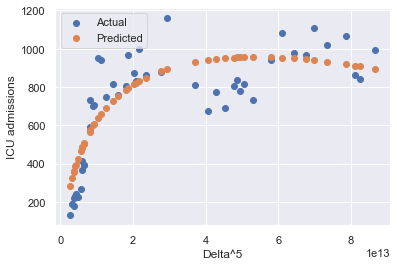

In [296]:
plt.scatter(df_features_test["Delta^5"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^5"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Delta^5")
plt.legend()

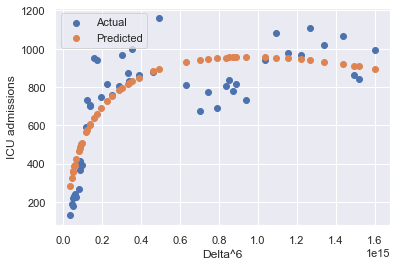

In [297]:
plt.scatter(df_features_test["Delta^6"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^6"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Delta^6")
plt.legend()

In [298]:
# TESTS
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 4)
print(a_r2, "Adjusted")

# 0.707 , 1.7, 5.5, 6

0.7072450578564545 Adjusted


### **Transit**

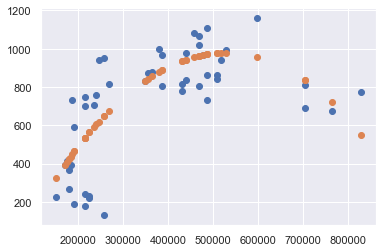

In [299]:
df_features_second = transform_features_power(df_feature_transit, 'Transit', 'Transit^3', 3)
df_features_second = transform_features_power(df_features_second, 'Transit', 'Transit^5', 5)
df_features_second = transform_features_power(df_features_second, 'Transit', 'Transit^7', 7)
df_features_second = transform_features_power(df_features_second, 'Transit', 'Transit^9', 9)

# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((6,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# print(beta)
pred = predict(df_features_test, beta)

sns.set()

plt.scatter(df_features_test["Transit^3"], df_target_test)
plt.scatter(df_features_test["Transit^3"], pred)


In [300]:
# TESTS
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 5)
print(a_r2, "Adjusted")

0.5361551296252884 Adjusted


## Multiple Linear Regression
<a id="multi"></a>

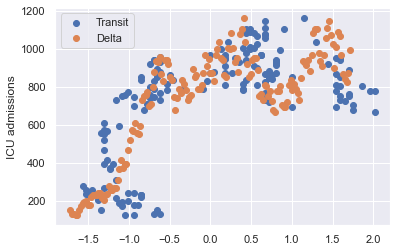

In [301]:
df_features, df_target = get_features_targets(df,["Transit", "Delta"],["ICU admissions"])

df_features = normalize_z(df_features)

plt.scatter(df_features["Transit"], df_target, label="Transit")
plt.scatter(df_features["Delta"], df_target, label="Delta")
plt.ylabel("ICU admissions")
plt.legend()


[[736.00864078]
 [-22.1222036 ]
 [234.85040057]]


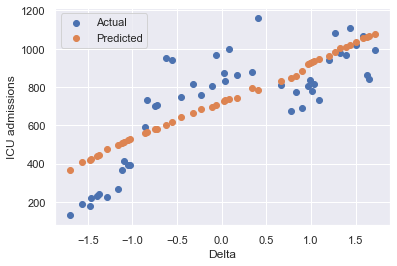

In [302]:
df_features_third = df_features

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_third, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((3,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

print(beta)
pred = predict(df_features_test, beta)
# print(pred)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Delta")
plt.legend()

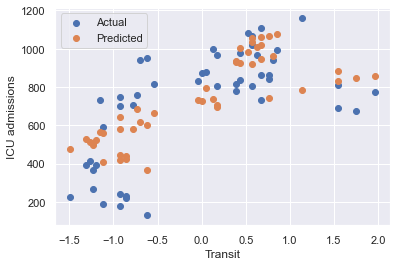

In [303]:
plt.scatter(df_features_test["Transit"], df_target_test, label="Actual")
plt.scatter(df_features_test["Transit"], pred, label="Predicted")
plt.ylabel("ICU admissions")
plt.xlabel("Transit")
plt.legend()

In [304]:
# TESTS
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 2)
print(a_r2, "Adjusted")

0.616369712791238 Adjusted


## Model Evaluation

Steps taken to improve accuracy of model
1. Logging features
2. Adjusting the power of polynomial linear regression model
3. Research for other possible features
4. Removing outliers

